Most of these data are time series. We can use R's STL to differentiate seasonal, trend and residual components. (It looks slightly better and smooth when compared with `statsmodels`'s seasonal_decompose.)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from rpy2.robjects import r

%matplotlib inline

In [2]:
records_iq = pd.read_csv(
    './generated/1-features-iq.csv', 
    parse_dates=['week_start_date'], 
    index_col='week_start_date')
records_sj = pd.read_csv(
    './generated/1-features-sj.csv', 
    parse_dates=['week_start_date'], 
    index_col='week_start_date')

Impute data using linear interpolation to get a first approximation. 

In [3]:
records_iq_i1 = records_iq.interpolate().drop(['weekofyear'], axis=1)
records_sj_i1 = records_sj.interpolate().drop(['weekofyear'], axis=1)

In [4]:
def stl_decompose(df, column, freq=52):
    dfd = pd.DataFrame(index=df.index)
    series = list(df[column].values)
    length = len(series)
    rts = r.ts(series, frequency=freq)
    decomposed = list(r.stl(rts, 'periodic', robust=True).rx2('time.series'))
    dfd['trend'] = decomposed[length:2*length]
    dfd['seasonal'] = decomposed[0:length]
    dfd['residuals'] = decomposed[2*length:3*length]
    
    return dfd

In [5]:
def stl_multi_decompose(df):
    trend = pd.DataFrame(index=df.index)
    seasonal = pd.DataFrame(index=df.index)
    residuals = pd.DataFrame(index=df.index)
    
    for col in df.columns:
        dfd = stl_decompose(df, col)
        trend[col] = dfd['trend']
        seasonal[col] = dfd['seasonal']
        residuals[col] = dfd['residuals']
    
    return {'trend': trend, 'seasonal': seasonal, 'residuals': residuals}

In [6]:
def correlation_heatmap_drop(df, title, f):
    corr = df.corr()
    plt.figure(figsize=(8, 6))
    corr_hm = sns.heatmap(corr)
    plt.title(title)
    
    corr_upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
    to_drop = [column for column in corr_upper.columns 
               if any(corr_upper[column] > f) or any(corr_upper[column] < -f)]
    return to_drop

In [7]:
def drop_extreme_correlated(dec_df, f=0.95):
    for k, v in dec_df.items():
        to_drop = correlation_heatmap_drop(v, 'Iquitos' + k, f)
        print('Dropping ' + str(to_drop) + ' in ' + k)
        v.drop(to_drop, axis=1, inplace=True)

In [8]:
dec_iq = stl_multi_decompose(records_iq_i1)

Dropping [] in trend
Dropping ['reanalysis_tdtr_k'] in seasonal
Dropping [] in residuals


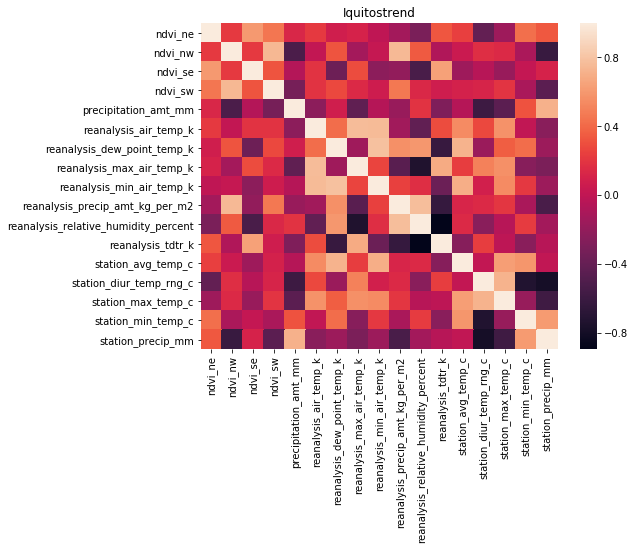

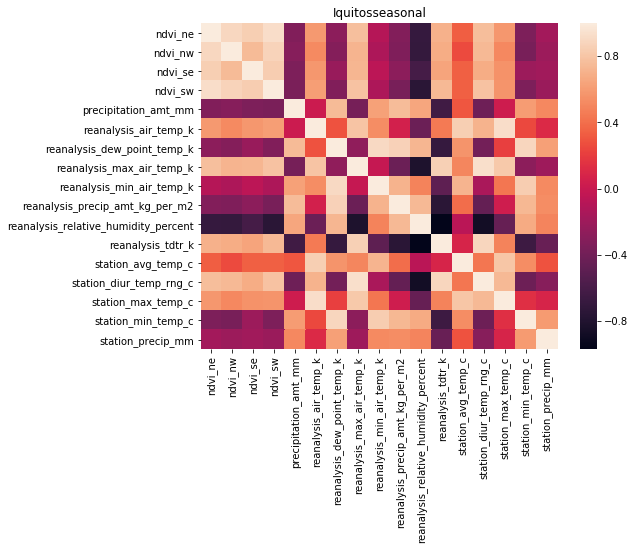

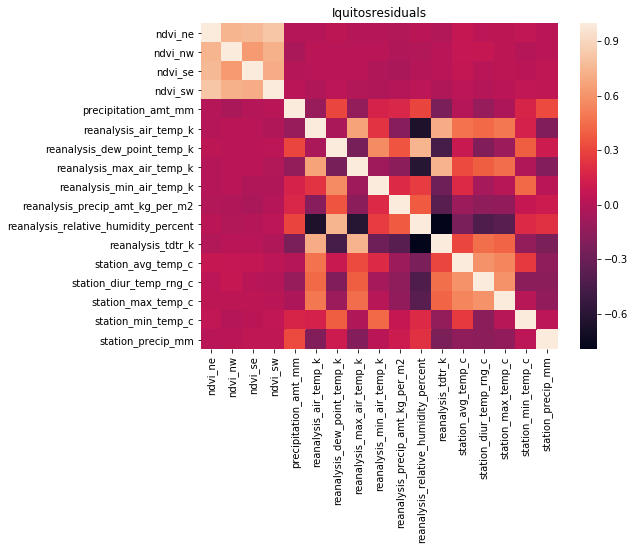

In [9]:
drop_extreme_correlated(dec_iq)

In [10]:
dec_sj = stl_multi_decompose(records_sj_i1)

Dropping ['reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k'] in trend
Dropping ['reanalysis_dew_point_temp_k', 'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k', 'station_avg_temp_c', 'station_max_temp_c', 'station_min_temp_c'] in seasonal
Dropping [] in residuals


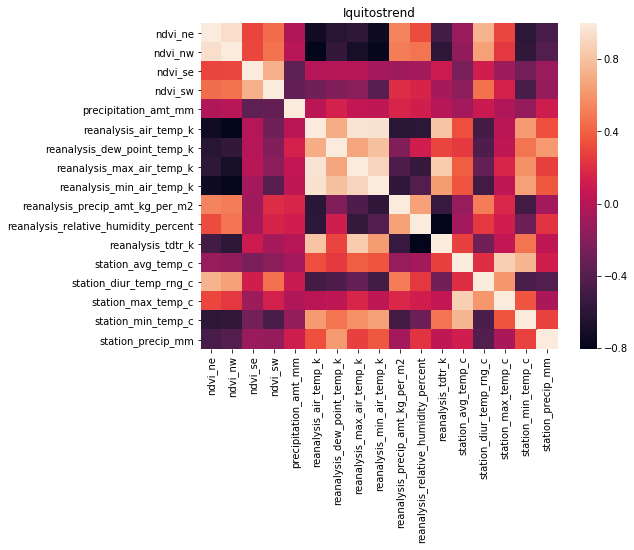

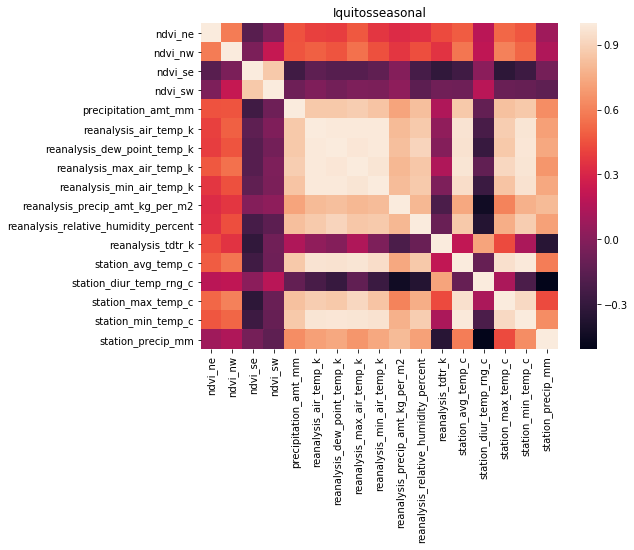

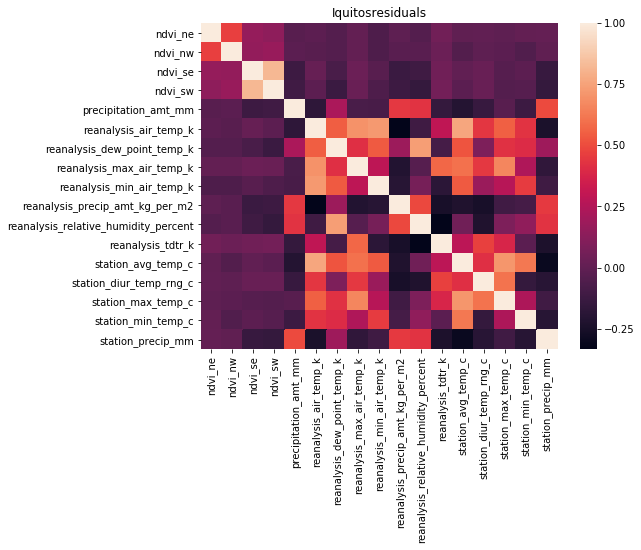

In [11]:
drop_extreme_correlated(dec_sj)

NDVIs show correlations inside residuals. Maybe this is not exactly a time series. 

In [12]:
stl_dec_iq = pd.concat(map(lambda kvp: kvp[1].add_prefix(kvp[0] + '_'), dec_iq.items()), axis=1)
stl_dec_sj = pd.concat(map(lambda kvp: kvp[1].add_prefix(kvp[0] + '_'), dec_sj.items()), axis=1)

In [13]:
stl_dec_iq.to_csv('./generated/2-time-dec-features-iq.csv', index_label='week_start_date')
stl_dec_sj.to_csv('./generated/2-time-dec-features-sj.csv', index_label='week_start_date')

---

 Try loading total cases:

In [14]:
training_targets_iq = pd.read_csv(
    './generated/1-labels-train-iq.csv', 
    parse_dates=['week_start_date'], 
    index_col='week_start_date')
training_targets_sj = pd.read_csv(
    './generated/1-labels-train-sj.csv', 
    parse_dates=['week_start_date'], 
    index_col='week_start_date')

In [15]:
# int not supported - float only
training_targets_iq['total_cases'] += 0.0
training_targets_sj['total_cases'] += 0.0

In [16]:
dec_targets_iq = stl_decompose(training_targets_iq, 'total_cases')
dec_targets_sj = stl_decompose(training_targets_sj, 'total_cases')

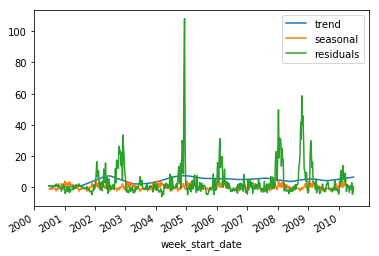

In [17]:
dec_targets_iq.plot()

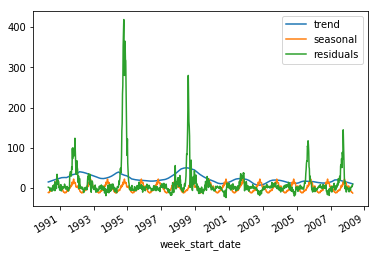

In [18]:
dec_targets_sj.plot()

Looks pointless. 

In [19]:
from fbprophet import Prophet

In [20]:
prophet_iq = Prophet()
prophet_sj = Prophet()

In [21]:
prophet_targets_iq = pd.DataFrame(
    {'ds': training_targets_iq.index.values, 'y': training_targets_iq.total_cases})
prophet_targets_sj = pd.DataFrame(
    {'ds': training_targets_sj.index.values, 'y': training_targets_sj.total_cases})

In [22]:
prophet_iq.fit(prophet_targets_iq)
prophet_sj.fit(prophet_targets_sj)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\umste\Anaconda3\envs\datasc\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [23]:
future_iq = prophet_iq.make_future_dataframe(periods=156)
future_sj = prophet_sj.make_future_dataframe(periods=260)

In [24]:
forecast_iq = prophet_iq.predict(future_iq)
forecast_sj = prophet_sj.predict(future_sj)

In [25]:
forecast = pd.concat([forecast_sj[['yhat_lower', 'yhat', 'yhat_upper']].tail(260), 
                     forecast_iq[['yhat_lower', 'yhat', 'yhat_upper']].tail(156)])

In [26]:
forecast = forecast[['yhat']].round().clip_lower(0)

In [27]:
forecast.astype(int).to_csv('./generated/2-fbprophet-forecast.csv', index=False)

Compared with the submitted results. Pretty much useless. 

---